In [3]:
import matplotlib.pylab as plt
import numpy as np

%matplotlib inline

In [4]:
def plti(im, h=8, **kwargs):
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, **kwargs)
    plt.axis('off')

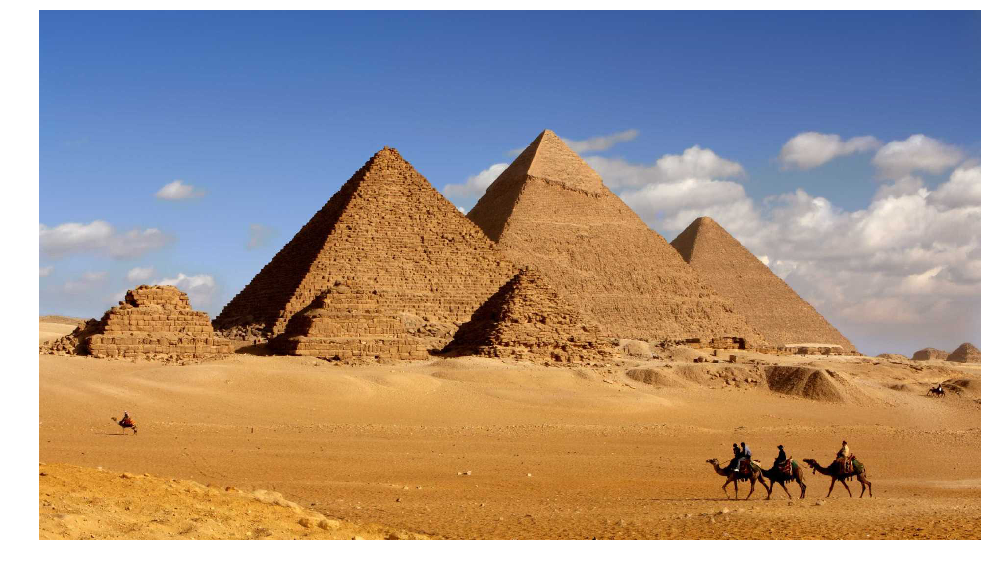

In [5]:
img = plt.imread("imagens/mmq/11.jpg")
plti(img, h=30)

In [6]:
def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    tile = np.tile(weights, reps=(im.shape[0],im.shape[1],1))
    return 256 - np.sum(tile * im, axis=2)

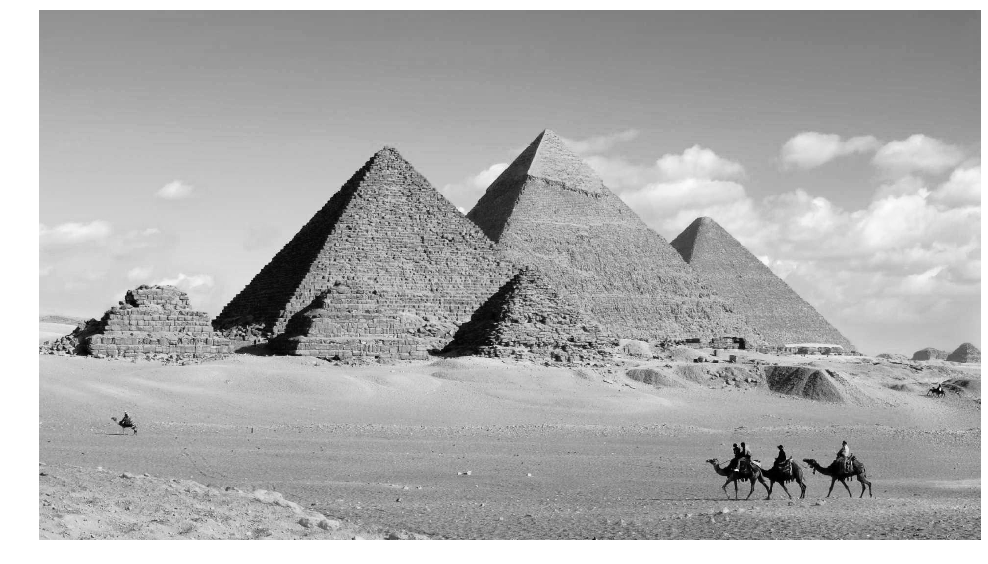

In [7]:
blk = to_grayscale(img, [0.33, 0.33, 0.33])
plti(blk, 30, cmap='Greys')

In [8]:
from scipy.signal import convolve2d

# sobel_d = np.c_[
#     [-2,-1, 0],
#     [-1, 0, 1],
#     [ 0, 1, 2]]

# sobel_x = np.c_[
#     [-1, 0, 1],
#     [-2, 0, 2],
#     [-1, 0, 1]]

# sobel_u = np.c_[
#     [ 0, 1, 2],
#     [-1, 0, 1],
#     [-2,-1, 0]]

# sobel_y = np.c_[
#     [ 1, 2, 1],
#     [ 0, 0, 0],
#     [-1,-2,-1]]

sobel_d = np.c_[
    [ 2, 1, 0],
    [ 1, 0,-1],
    [ 0,-1,-2]]

sobel_x = np.c_[
    [ 1, 0,-1],
    [ 2, 0,-2],
    [ 1, 0,-1]]

sobel_u = np.c_[
    [ 0,-1,-2],
    [ 1, 0,-1],
    [ 2, 1, 0]]

sobel_y = np.c_[
    [-1,-2,-1],
    [ 0, 0, 0],
    [ 1, 2, 1]]

def convolve(img, window):
    return convolve2d(img, window, mode="same", boundary="symm")

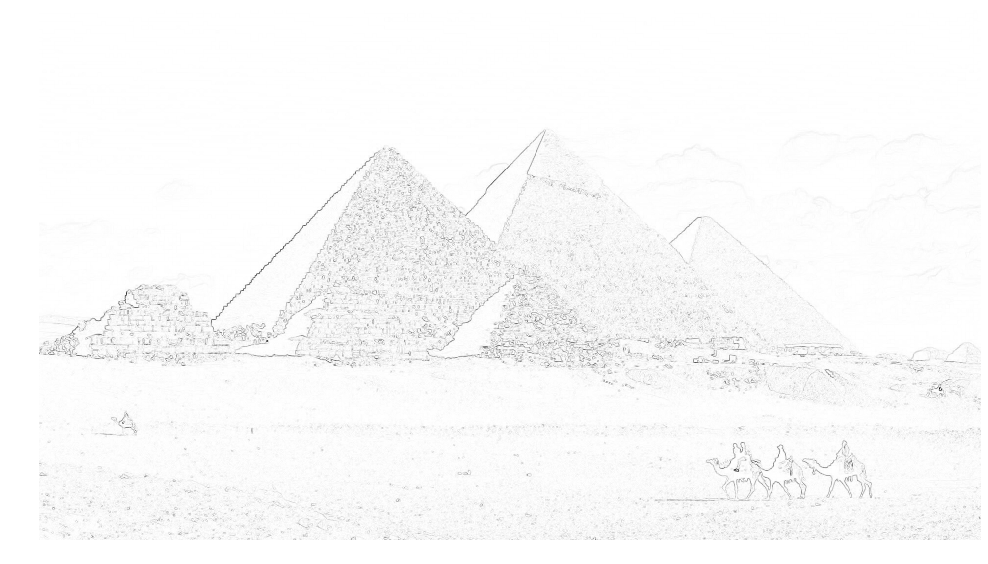

In [9]:
aux = np.maximum(abs(convolve(blk, sobel_y)), abs(convolve(blk, sobel_x)))
aux = np.maximum(abs(convolve(blk, sobel_u)), aux)
aux = np.maximum(abs(convolve(blk, sobel_d)), aux)
plti(aux, 30, cmap='Greys')

In [10]:
def simple_threshold(img, threshold=128):
    return ((img > threshold) * 255).astype("uint8")

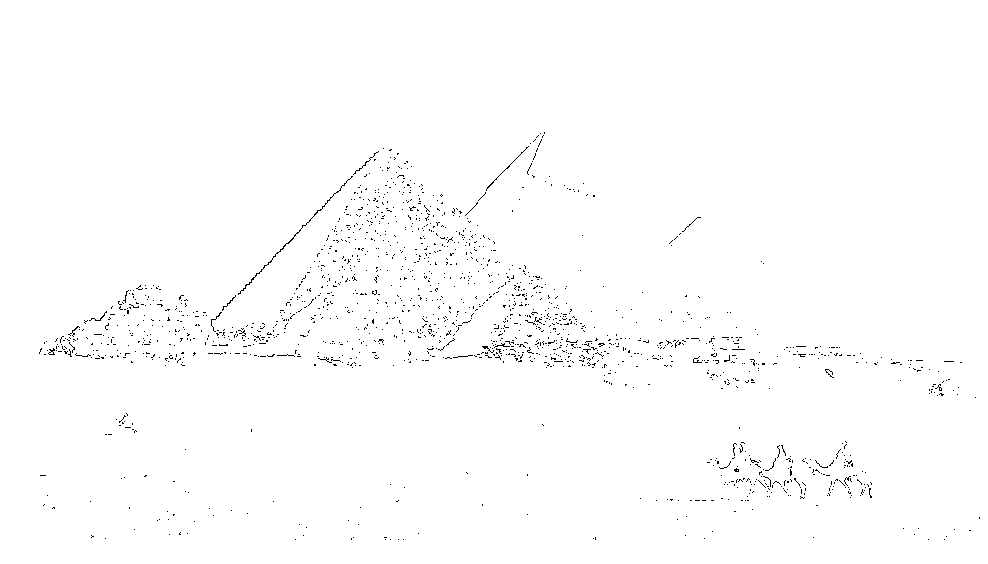

In [11]:
thr = simple_threshold(aux, (aux.max() + aux.min()) // 3)
plti(thr, 30, cmap='Greys')

In [12]:
from math import sqrt

def get_AB(points):
    A = np.array([(point[0], 1) for point in points])
    B = np.array([(point[1],) for point in points])
    return A, B

def get_ABW(points, point):
    A = np.array([(p[0], 1) for p in points])
    B = np.array([(p[1],) for p in points])
    auxW = [sqrt((point[0] - p[0])**2 + (point[1] - p[1])**2) for p in points]
    maxW = max(auxW)
    W = np.diag([1 - (w/maxW) for w in auxW])
    return A, B, W

In [13]:
def least_square(A, B):
    ATA = A.T.dot(A)
    ATB = A.T.dot(B)
    mat = np.concatenate([ATA, ATB], axis=1)
    for i in range(2):
        mat = mat / mat[:,[i]]
        for j in range(2):
            if j != i:
                mat[[j],:] -= mat[[i],:]
    for i in range(2):
        mat[[i],:] /= mat[i,i]
    return mat[0,2], mat[1,2], lambda x : mat[0,2]*x + mat[1,2]

def weigth_least_square(A, B, W):
    ATA = A.T.dot(W).dot(A)
    ATB = A.T.dot(W).dot(B)
    mat = np.concatenate([ATA, ATB], axis=1)
    for i in range(2):
        mat = mat / mat[:,[i]]
        for j in range(2):
            if j != i:
                mat[[j],:] -= mat[[i],:]
    for i in range(2):
        mat[[i],:] /= mat[i,i]
    return mat[0,2], mat[1,2], lambda x : mat[0,2]*x + mat[1,2]

In [14]:
def get_points(img, y, x, lenY, lenX, error):
    points = [(x, y)]
    img[y, x] -= 1
    minX = x - error
    minY = y - error
    maxX = x + error + 1
    maxY = y + error + 1
    for j in range(max(0, minY), min(lenY, maxY)):
        for i in range(max(0, minX), min(lenX, maxX)):
            if img[j, i] == 255:
                p = get_points(img, j, i, lenY, lenX, error)
                points.extend(p)
    return points

In [15]:
def get_components(img, error=1):
    components = []
    (lenY, lenX) = img.shape
    for y in range(lenY):
        for x in range(lenX):
            if img[y, x] == 255:
                c = get_points(img, y, x, lenY, lenX, error)
                components.append(c)
    for y in range(lenY):
        for x in range(lenX):
            if img[y, x] > 0:
                img[y, x] = 255
    return [set(c) for c in components if len(c) > 1]

In [16]:
def mae(points, func):
    error = [abs(func(x) - y) for x, y in points]
    return sum(error)/len(error)

In [17]:
components = get_components(thr, error=2)

In [18]:
def get_lines(components, num=float('inf'), error=10, tol=2, it=0):
    final_lines = []
    len_mae = lambda r: (r[0]/max_len)*(1 - (r[1]/max_mae))
    while len(components) != 0 and len(final_lines) < num:
        lines = [least_square(A, B) for A, B in [get_AB(p) for p in components]]
        metrics = [(len(p), mae(p, lines[i][2])) for i, p in enumerate(components)]
        max_len, max_mae = max([r[0] for r in metrics]), max([r[1] for r in metrics]) * tol
        ranks = sorted([(len_mae(r), i) for i, r in enumerate(metrics) if r[1] == r[1]], reverse=True)
        
        index = ranks[0][1]
        line = lines[index]
        size = len(components[index])
        point = (sum([p[0] for p in components[index]])/size, sum([p[1] for p in components[index]])/size)
        
        error_mae = error
        for p in components[index]:
            value = abs(line[2](p[0]) - p[1])
            if error_mae < value:
                error_mae = value
        for i in range(it):
            points = []
            for c in components:
                for p in c:
                    value = abs(line[2](p[0]) - p[1])
                    if error_mae >= value:
                        points.append(p)
            A, B, W = get_ABW(points, point)
            line = weigth_least_square(A, B, W)
            
            error_mae = error
            for p in components[index]:
                value = abs(line[2](p[0]) - p[1])
                if error_mae < value:
                    error_mae = value

        for i, c in enumerate(components):
            components[i] = [p for p in c if error_mae < abs(line[2](p[0]) - p[1])]
        components = [c for c in components if len(c) > 1]
        final_lines.append(line)
    return final_lines

In [19]:
lines = get_lines(components[:], 20, 10, it=5)

/Users/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [20]:
def put_line(img, line, l=2):
    foto = img.copy()
    (lenY, lenX) = img.shape
    if line[0] < 0.5 and line[0] > -0.5:
        for x in range(lenX):
            i = int(round(line[2](x)))
            for y in range(i - l, i + l + 1):
                if y >= 0 and y < lenY:
                    foto[y, x] = 255
    else:
        for y in range(lenY):
            i = int(round((y - line[1])/line[0]))
            for x in range(i - l, i + l + 1):
                if x >= 0 and x < lenX:
                    foto[y, x] = 255
    return foto

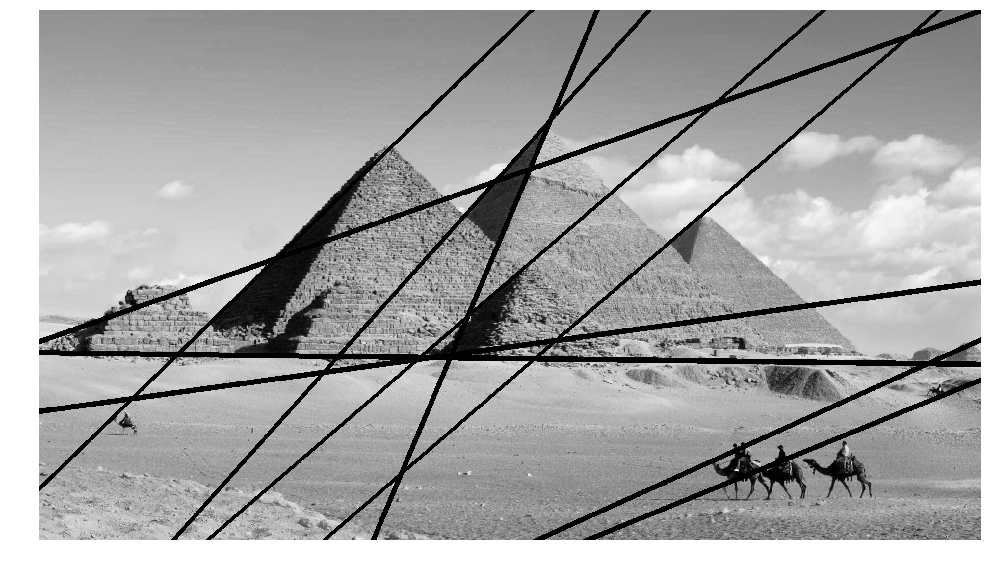

In [21]:
foto = blk.copy()
for line in lines[:10]:
    try:
        foto = put_line(foto, line, 5)
    except Exception:
        pass
plti(foto, 30, cmap='Greys')